https://medium.com/voxel51/finding-images-with-words-92b078314ed1

In [14]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from fiftyone import ViewField as F

import pinecone


from tqdm.notebook import tqdm

from config import PINECONE_KEY

In [2]:
dataset = foz.load_zoo_dataset("coco-2017", split="validation")
model = foz.load_zoo_model("clip-vit-base32-torch")

Found annotations at '/Users/laurendurivault/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [11.5s elapsed, 0s remaining, 465.8 samples/s]      
Dataset 'coco-2017-validation' created
 100% |█████|   10.4Mb/10.4Mb [83.2ms elapsed, 0s remaining, 124.5Mb/s]     



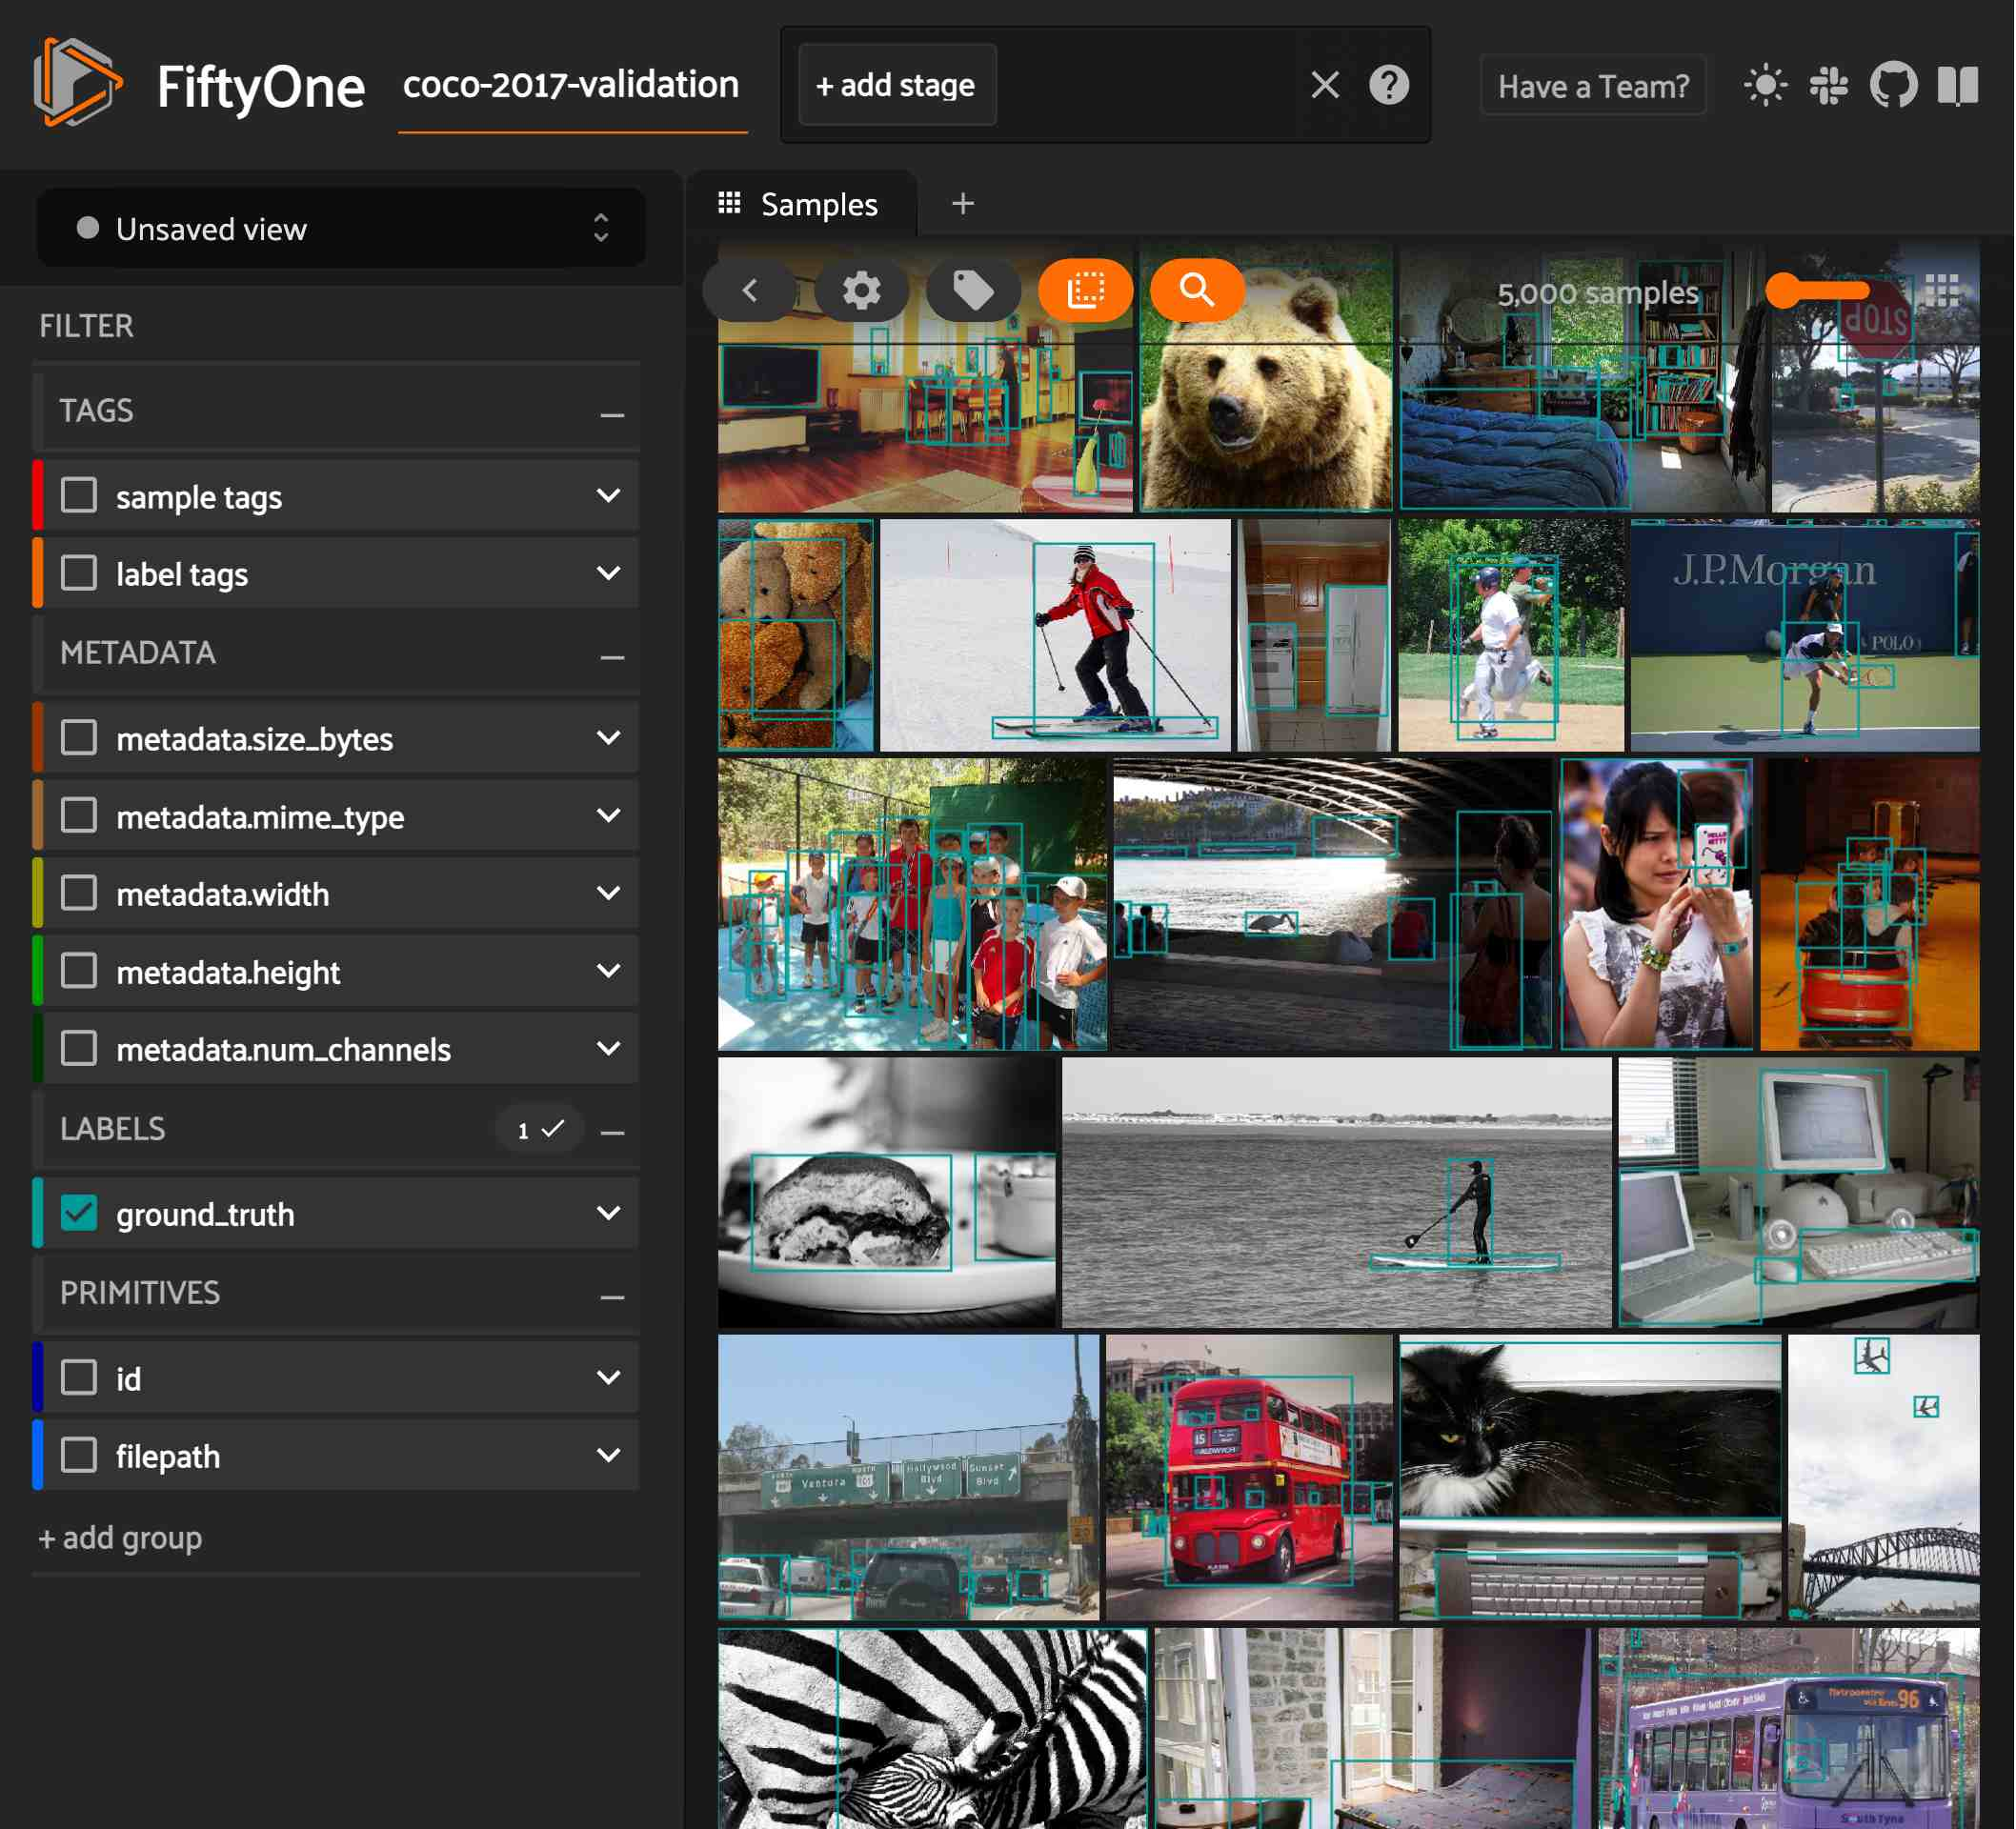

In [5]:
session = fo.launch_app(dataset)

In [12]:


pinecone.init(api_key=PINECONE_KEY, environment="us-east4-gcp")

In [7]:
import numpy as np
from pkg_resources import packaging
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

if packaging.version.parse(
  torch.__version__
) < packaging.version.parse("1.8.0"):
  dtype = torch.long
else:
  dtype = torch.int

In [10]:
dataset.compute_embeddings(
    model, 
    embeddings_field="embedding",
)

 100% |███████████████| 5000/5000 [3.9m elapsed, 0s remaining, 23.5 samples/s]      


In [11]:
dataset.persistent = True

In [15]:
# perform dimensionality reduction using t-SNE
results = fob.compute_visualization(
    dataset, 
    embeddings = "embedding", 
    method = "tsne"
)

# visualize results, labeling by number of objects in image
results.visualize(labels=F("ground_truth.detections").length())

Generating visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.577s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.825601
[t-SNE] Computed conditional probabilities in 0.068s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 80.2232361, gradient norm = 0.0076838 (50 iterations in 0.853s)
[t-SNE] Iteration 100: error = 80.6894684, gradient norm = 0.0014514 (50 iterations in 0.639s)
[t-SNE] Iteration 150: error = 80.6947479, gradient norm = 0.0007131 (50 iterations in 0.642s)
[t-SNE] Iteration 200: error = 80.6884689, gradient norm = 0.0004270 (50 iterations in 0.663s)
[t-SNE] Iteration 250: error = 80.6842270, gradient norm = 0.0002153 (50 iterations in 0.680s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.684227
[t-SNE] Iteration 300: error = 2.1900101, gradient norm = 0.0011385 (50 iterations in 0.676s)
[t-SNE] Iteration 350: error = 1.8384509, gradient norm = 0.0004465 (50 iterations in 0.600s)
[t-SNE] Iteration 400: error = 1.6954247, gradient norm = 0.0002618 (50 iterations in 0.601s)
[t-SNE] Iteration 450: error = 1.6183579, gradient norm = 0.0001771 (50 iterations in 0.610s)
[t-SNE] Iteration 500: error = 1.5723797, gradient norm = 0.0001364 (50 

FigureWidget({
    'data': [{'customdata': array(['642af936fc00c8b9c5ecff06', '642af936fc00c8b9c5ecff1a',
    …

In [16]:
def get_text_embedding(prompt, clip_model):
    tokenizer = clip_model._tokenizer

    # standard start-of-text token
    sot_token = tokenizer.encoder["<|startoftext|>"]

    # standard end-of-text token
    eot_token = tokenizer.encoder["<|endoftext|>"]

    prompt_tokens = tokenizer.encode(prompt)
    all_tokens = [[sot_token] + prompt_tokens + [eot_token]]

    text_features = torch.zeros(
        len(all_tokens),
        clip_model.config.context_length,
        dtype=dtype,
        device=device,
    )

    # insert tokens into feature vector
    text_features[0, : len(all_tokens[0])] = torch.tensor(all_tokens)

    # encode text
    embedding = clip_model._model.encode_text(text_features).to(device)

    # convert to list for Pinecone
    return embedding.tolist()

In [17]:
prompt = "a picture of a giraffe"
query_vector = get_text_embedding(prompt, model)

In [18]:
indices = pinecone.list_indexes()
if len(indices) > 0:
    pinecone.delete_index(indices[0])

In [19]:
index_name = "my-index"
pinecone.create_index(
    index_name, 
    dimension=512, 
    metric="cosine", 
    pod_type="p1"
)
index = pinecone.Index(index_name)

In [20]:
# convert numpy arrays to lists for pinecone
embeddings = [arr.tolist() for arr in dataset.values("embedding")]
ids = dataset.values("id")

# create tuples of (id, embedding) for each sample
index_vectors = list(zip(ids, embeddings))

def upsert_vectors(index, vectors):
    num_vectors = len(vectors)
    num_vectors_per_step = 100
    num_steps = int(np.ceil(num_vectors/num_vectors_per_step))
    for i in range(num_steps):
        min_ind = num_vectors_per_step * i
        max_ind = min(num_vectors_per_step * (i+1), num_vectors)
        index.upsert(index_vectors[min_ind:max_ind])

upsert_vectors(index, index_vectors)


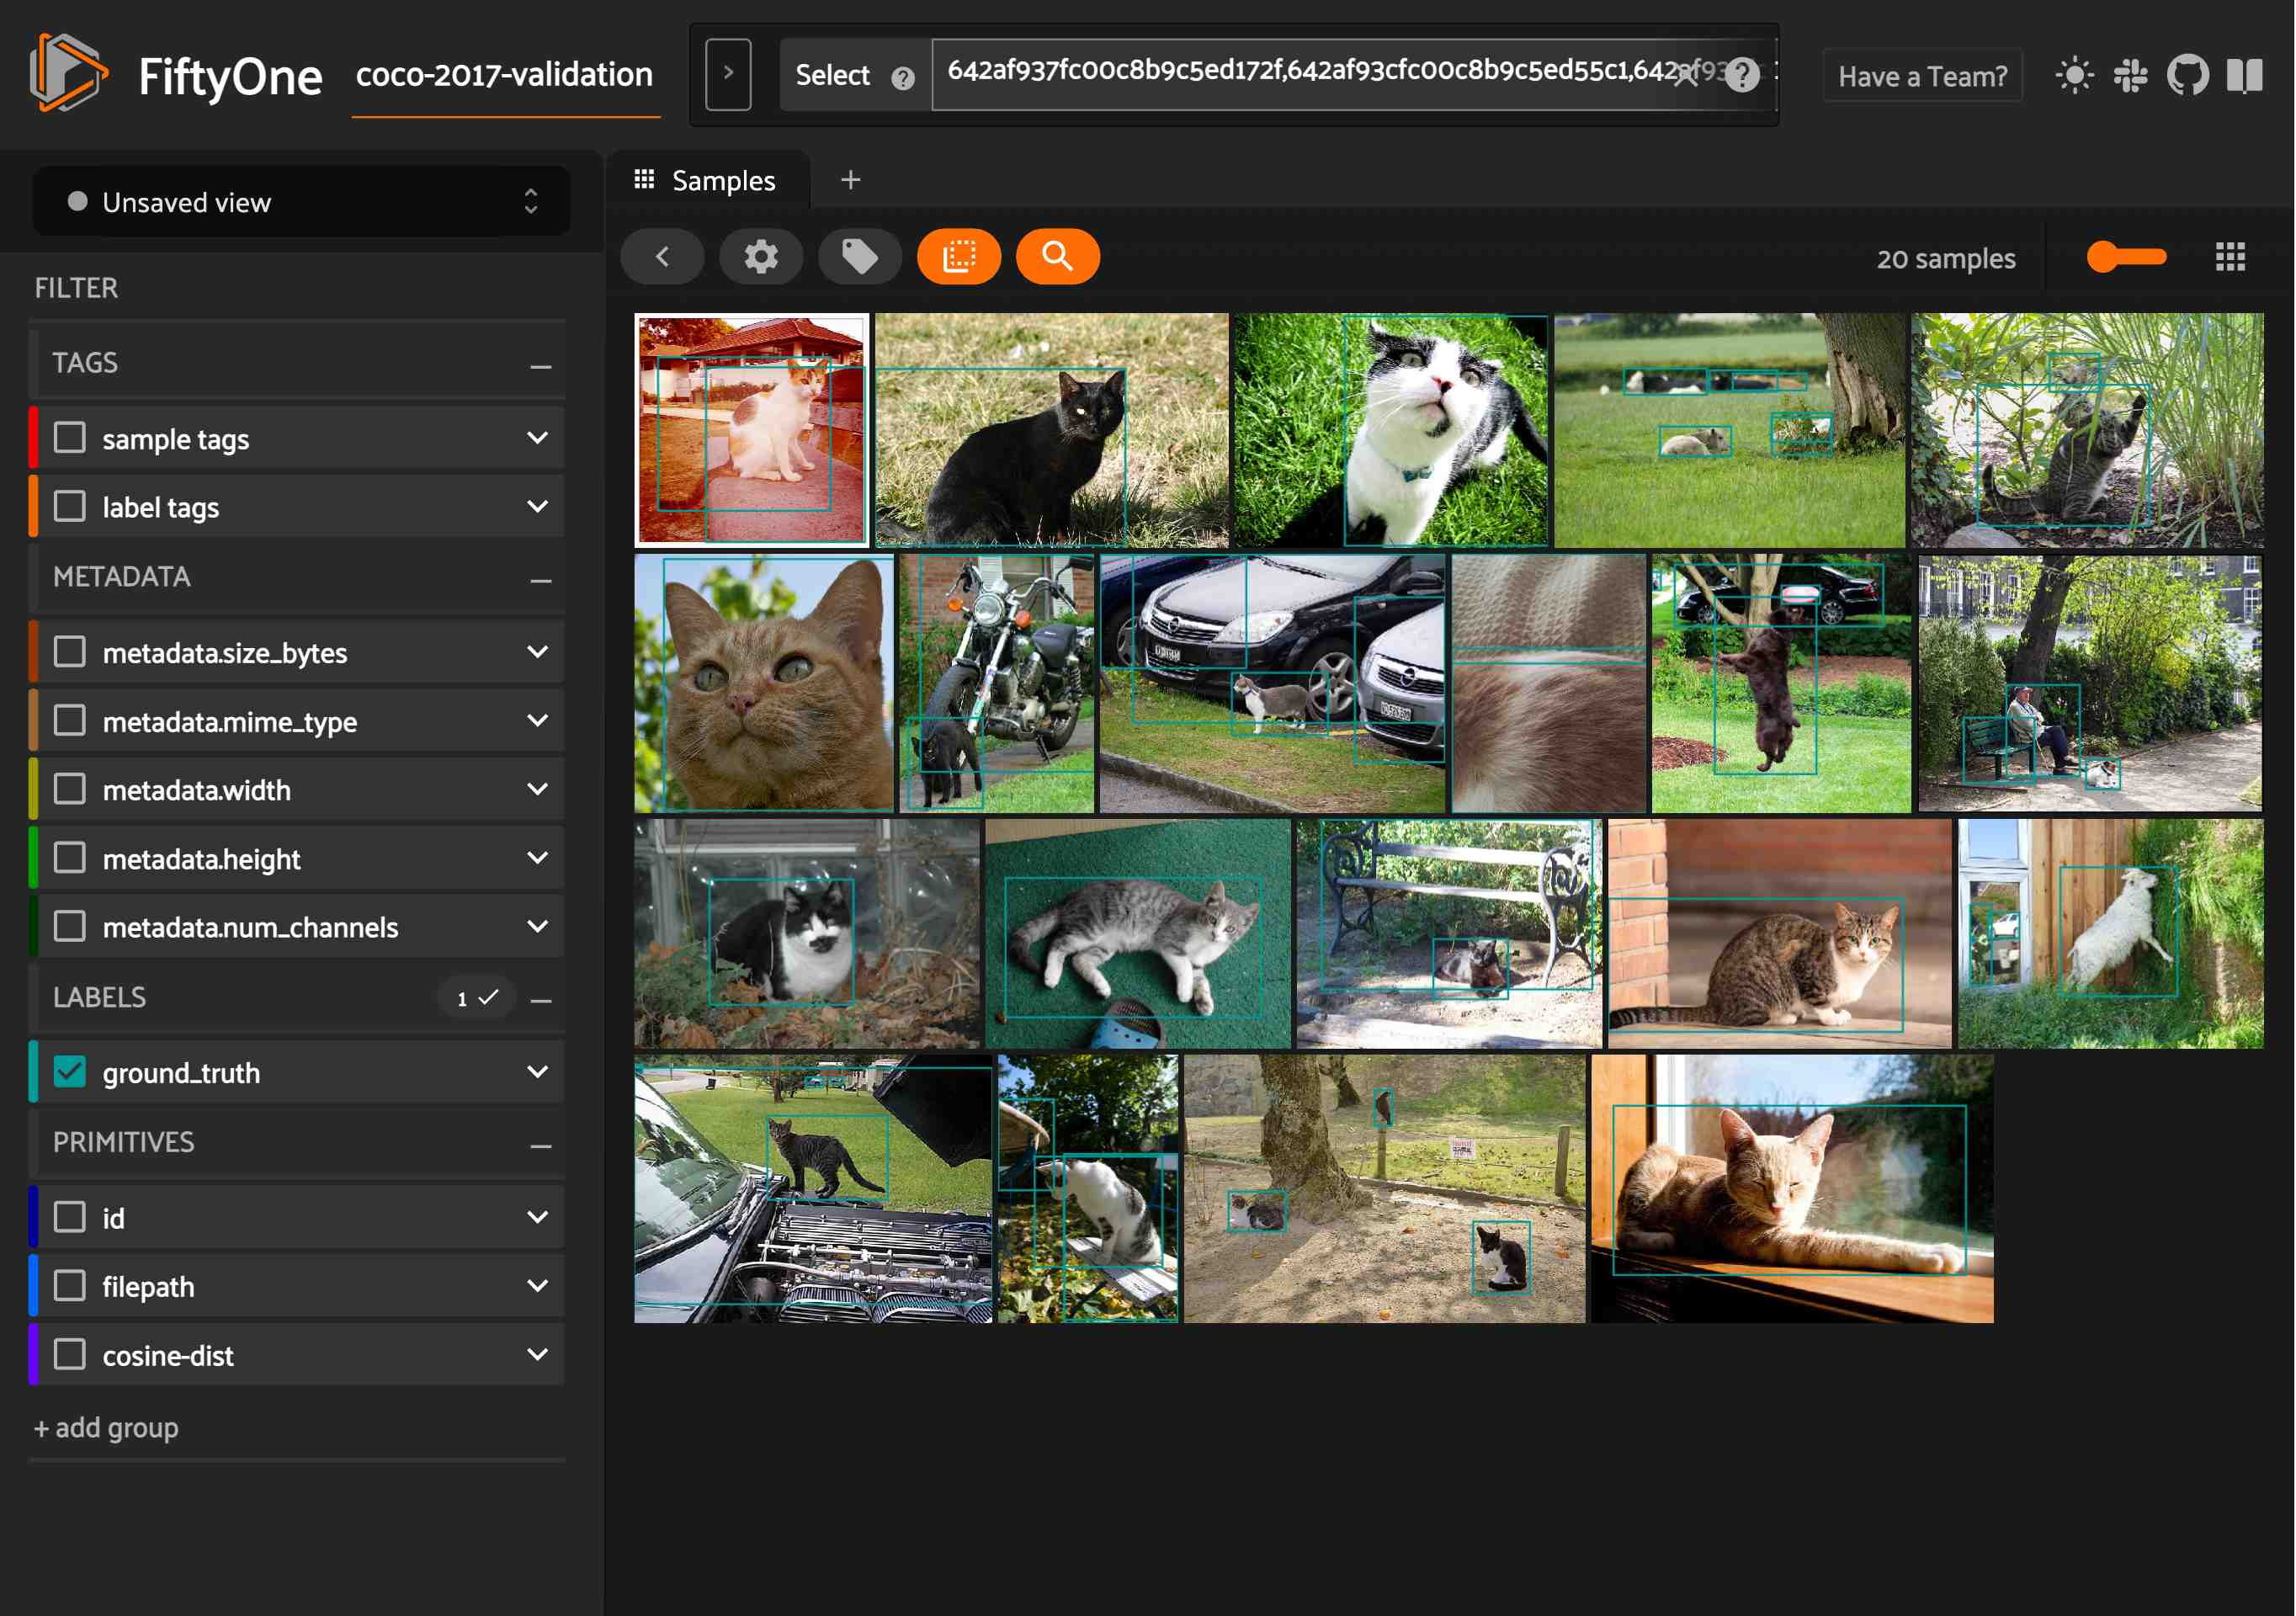

In [62]:
prompt = "a cat on the grass"
query_vector = get_text_embedding(prompt, model)
top_k_samples = index.query(
    vector=query_vector,
    top_k=20,
    include_values=False
)['matches']

# get ids of samples that most resemble a person holding a baseball bat
top_k_ids = [res['id'] for res in top_k_samples]

# view these samples, ordered by similarity
view = dataset.select(top_k_ids, ordered=True)
session.view = view.view()

In [56]:
def sort_by_semantic_similarity(
    dataset,
    index,
    prompt,
    k=None,
    score_field=None
):
    
    query_vector = get_text_embedding(prompt, model)
    if k is not None:
        top_k=k
    else:
        top_k = int(min(10000, dataset.count()))
        
    
    result_samples = index.query(
        vector=query_vector,
        top_k=top_k,
        include_values=False
    )['matches']
    
    sample_ids = [res['id'] for res in result_samples]
    view = dataset.select(sample_ids, ordered=True)

    if score_field is not None:
        scores = [res['score'] for res in result_samples]
        dataset.add_sample_field(score_field, fo.FloatField)
        view.set_values(score_field, scores)
        dataset.save()
    
    return view

In [63]:
prompt = "a cat in the rain"

view = sort_by_semantic_similarity(
    dataset, 
    index, 
    prompt, 
    k = 30, 
    score_field = "cosine-dist"
)

session.view = view.view()